In [1]:
import sys

import numpy as np
import pandas as pd
import shap

/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("../")

In [3]:
from mlexplainer.shap_explainer.binary_explainers import BinaryMLExplainer

In [4]:
dataframe = pd.read_csv('../tests/resources/samples/df_nba_rookie.csv')
dataframe.shape[0]

1340

In [5]:
dataframe["is_ok_3pts"] = dataframe["3PA"].apply(lambda u: "2 +" if u > 2 else "Entre 0 et 1" if u > 1 else "Moins de 1")

dataframe["is_ok_3pts"] = dataframe["is_ok_3pts"].astype("category")
dataframe["is_ok_3pts"].value_counts()

is_ok_3pts
Moins de 1      972
Entre 0 et 1    192
2 +             176
Name: count, dtype: int64

### Réalisation d'un modèle de base

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
dataframe['3P%_2'] = dataframe['3P%'].apply(lambda u: np.nan if u<15 else u)
del dataframe["Name"]

In [8]:
target = 'TARGET_5Yrs'
selected_features = [c for c in dataframe if (c != target) and c not in ["Name"]]

### Séparation en X et y ###
X, y = dataframe, dataframe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
fitted_model = model.fit(X_train[selected_features], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 560, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624303 -> initscore=0.507854
[LightGBM] [Info] Start training from score 0.507854


In [10]:
binary_explainer = BinaryMLExplainer(model=fitted_model, x_train=X_train[selected_features], 
y_train=y_train, features=selected_features)

/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


/Users/zachariebuisson/Documents/GitHub/mlexplainer/mlexplainer/shap_explainer/utils_shap_explainer/plotting.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["ranking"] = "a"
/Users/zachariebuisson/Documents/GitHub/mlexplainer/mlexplainer/shap_explainer/utils_shap_explainer/plotting.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["ranking"] = "a"


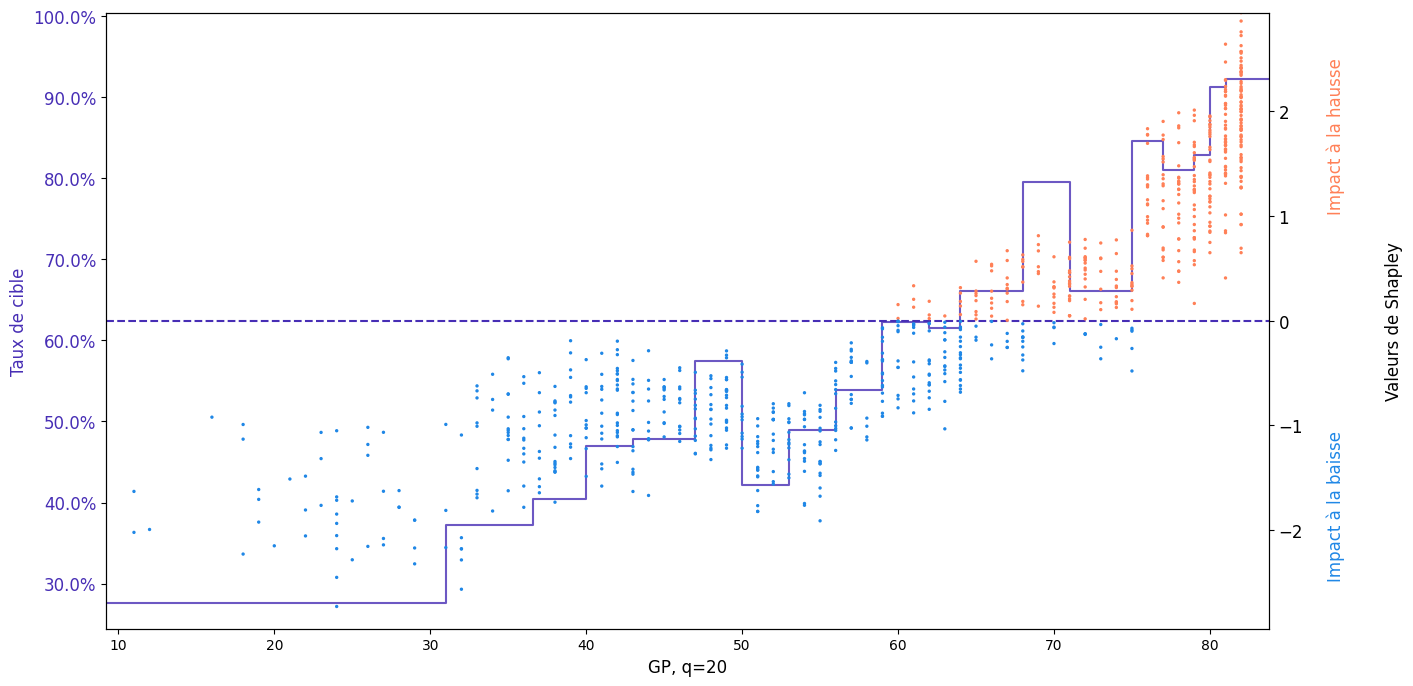

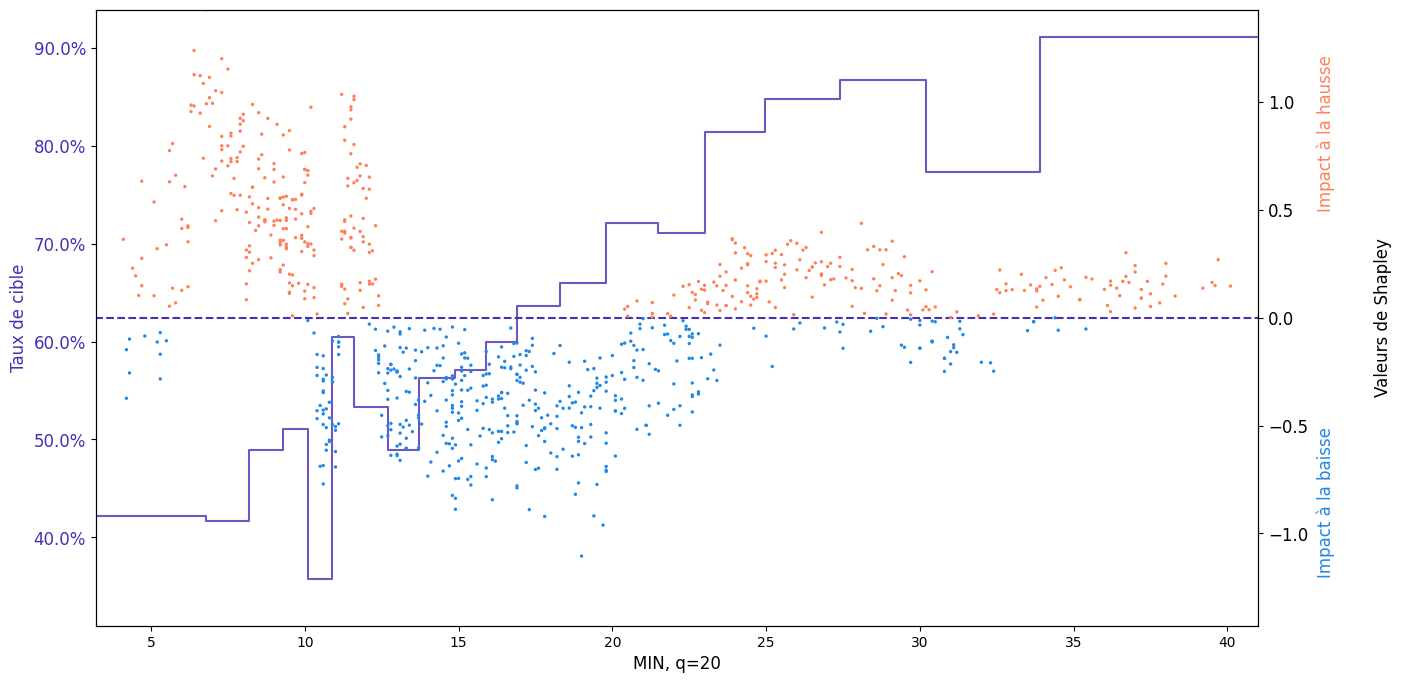

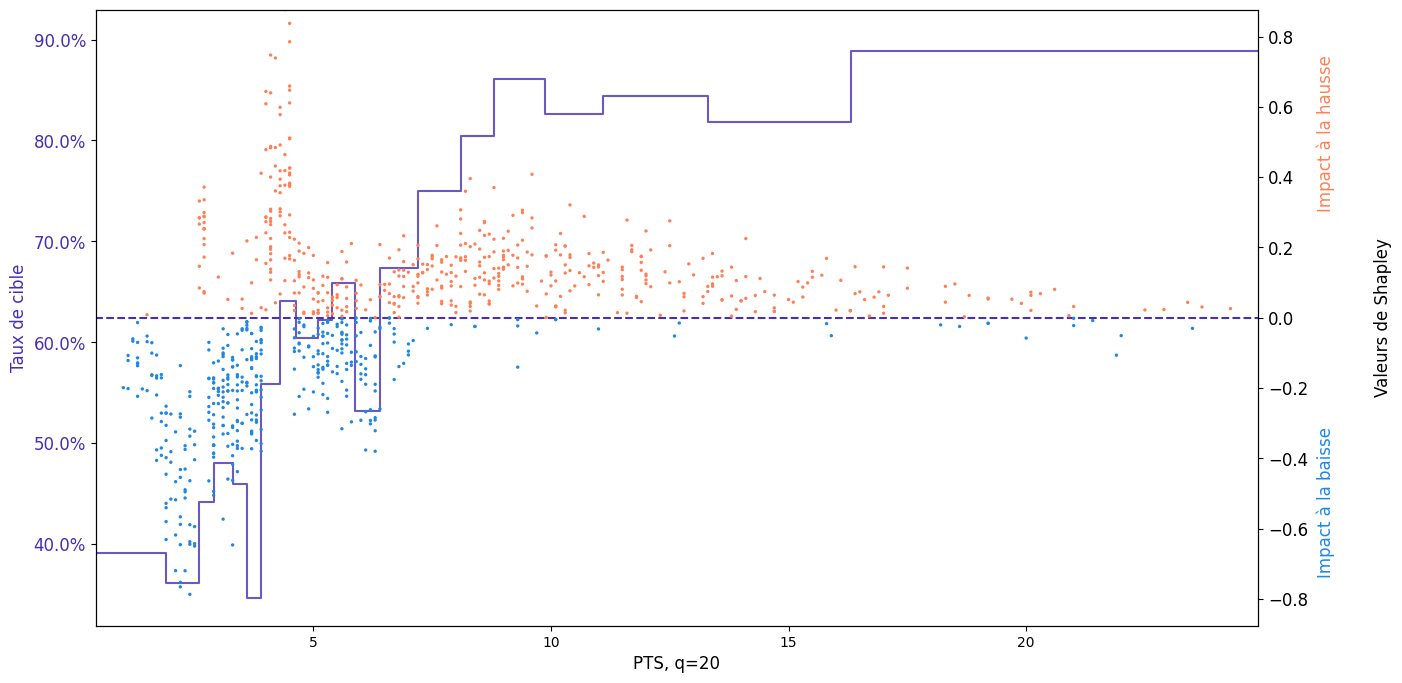

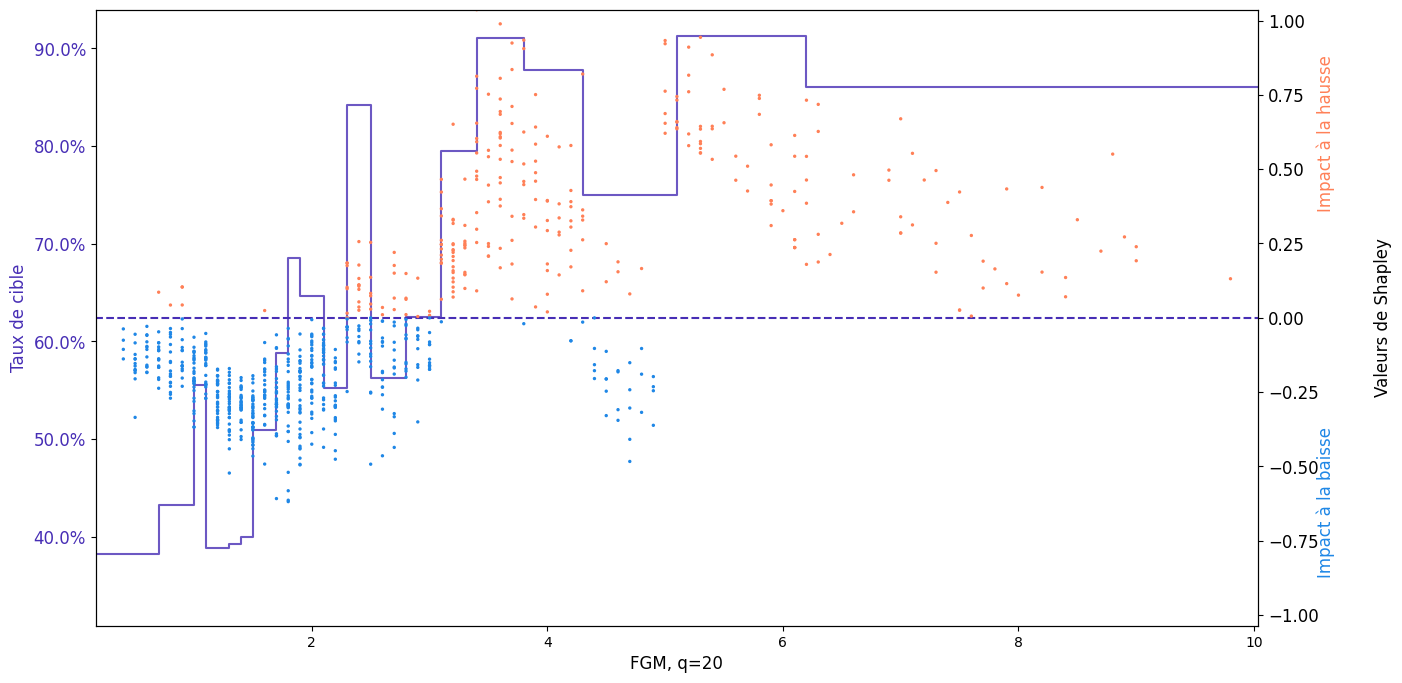

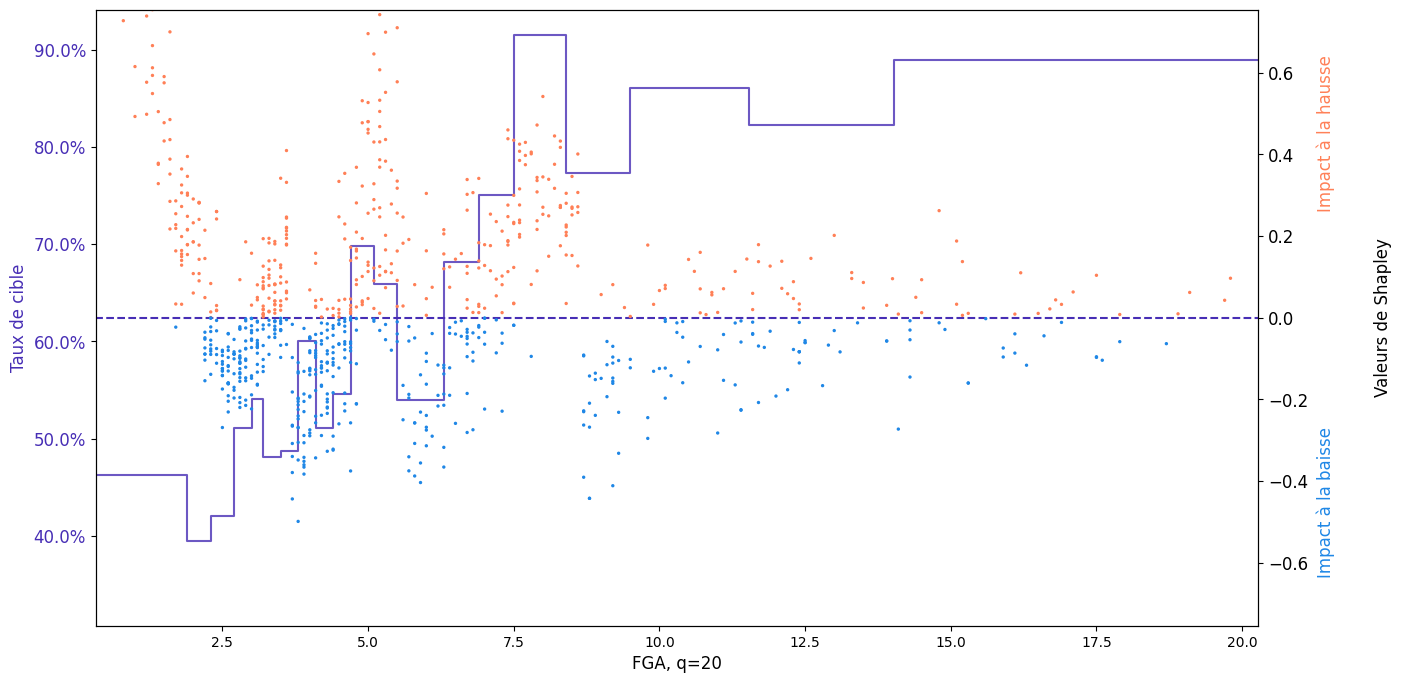

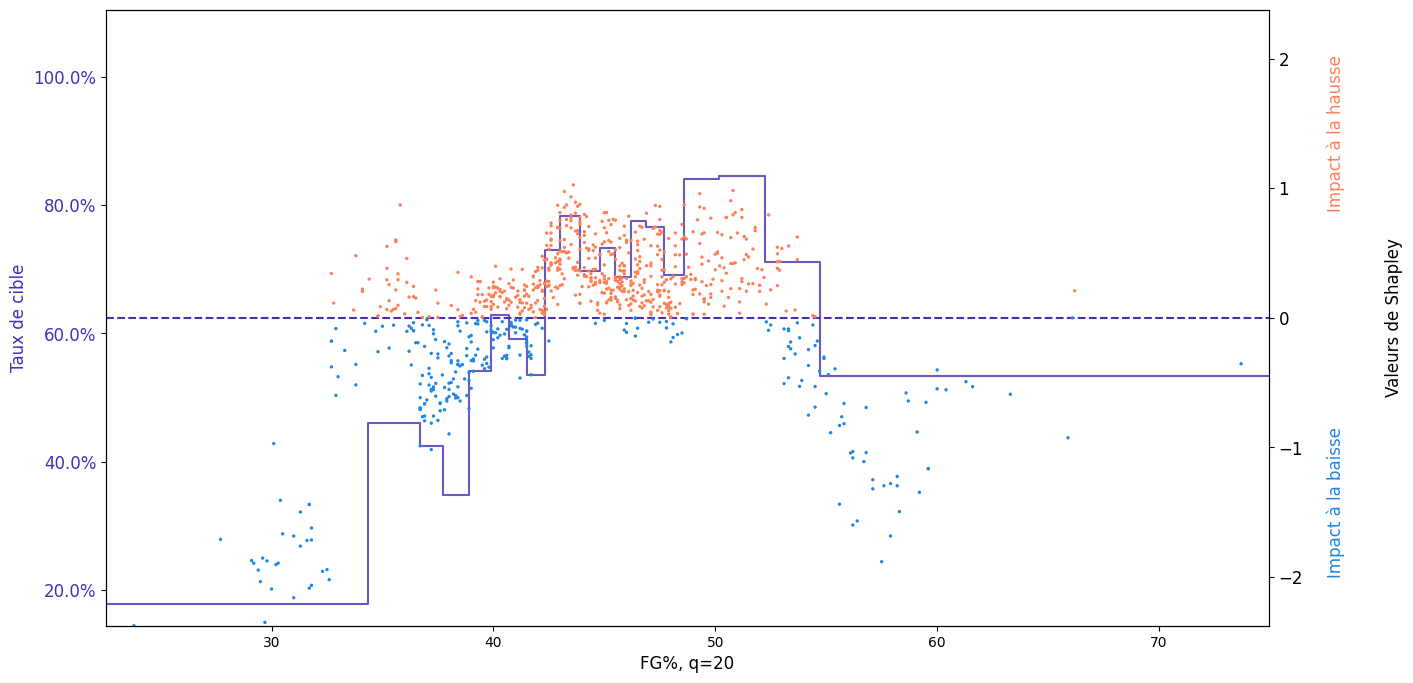

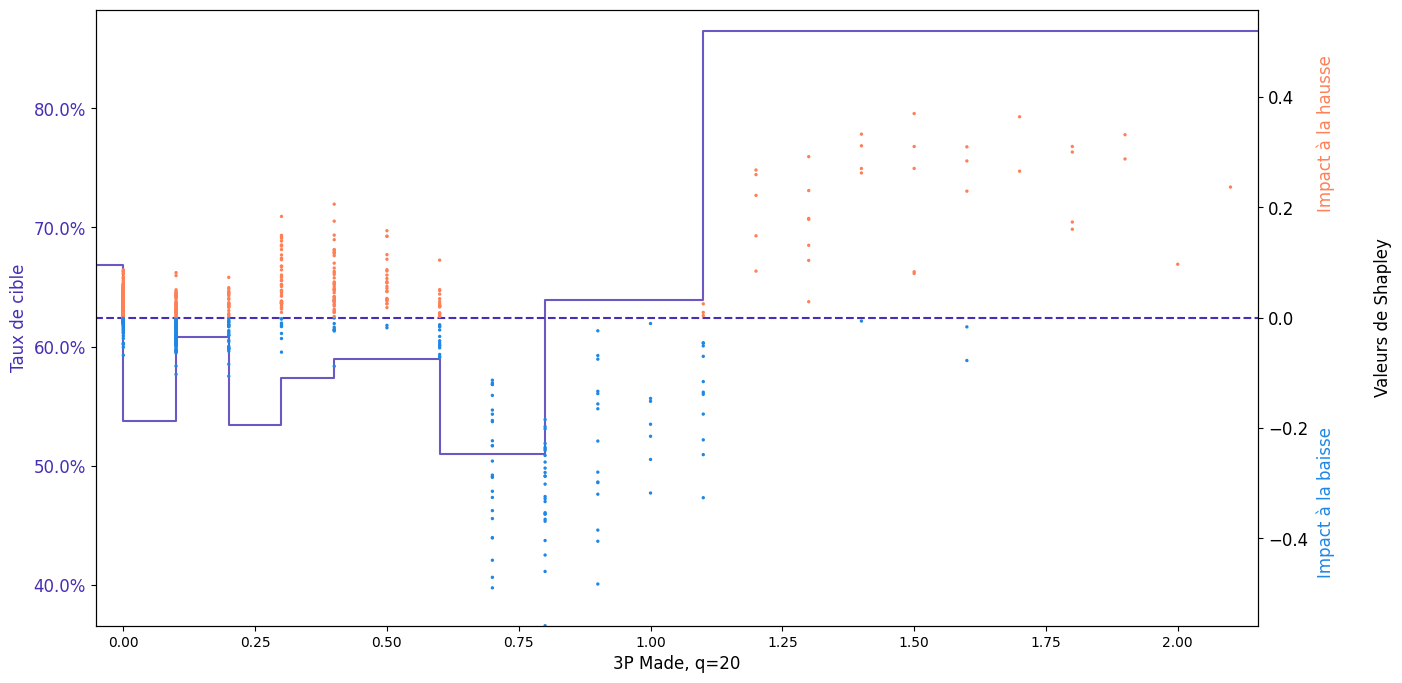

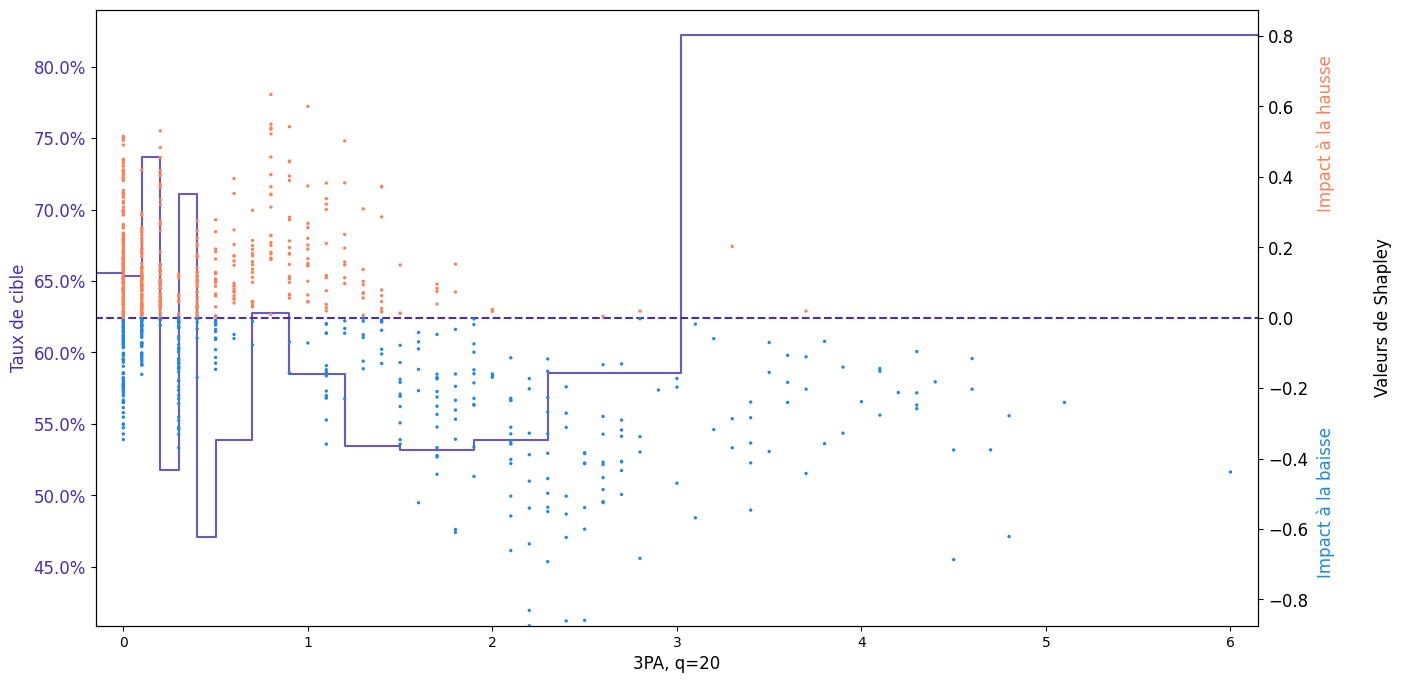

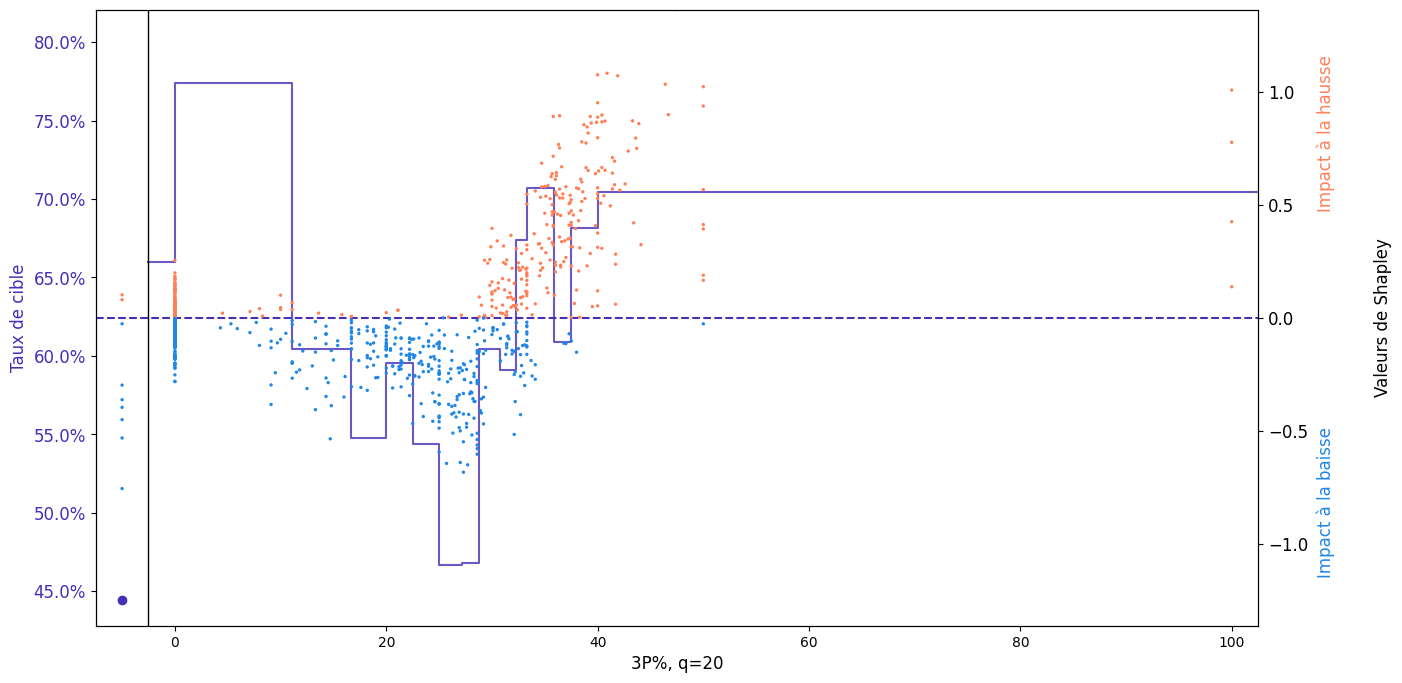

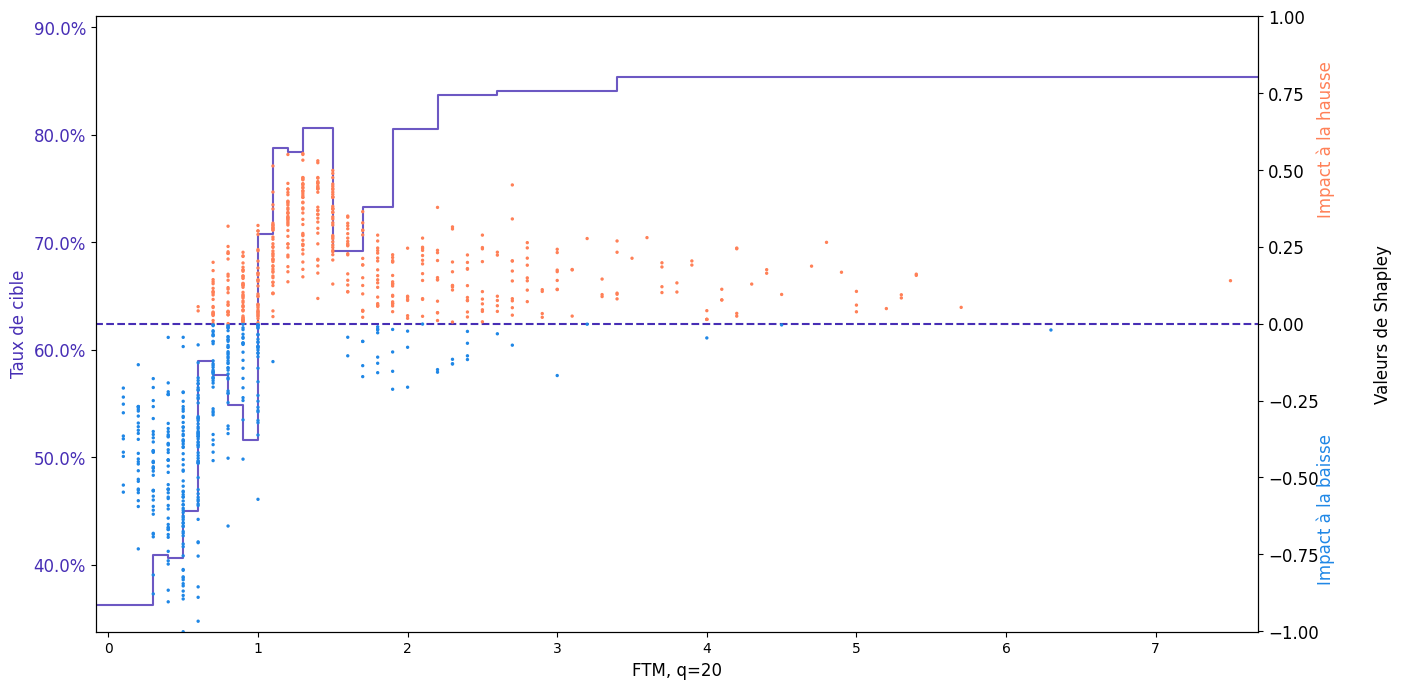

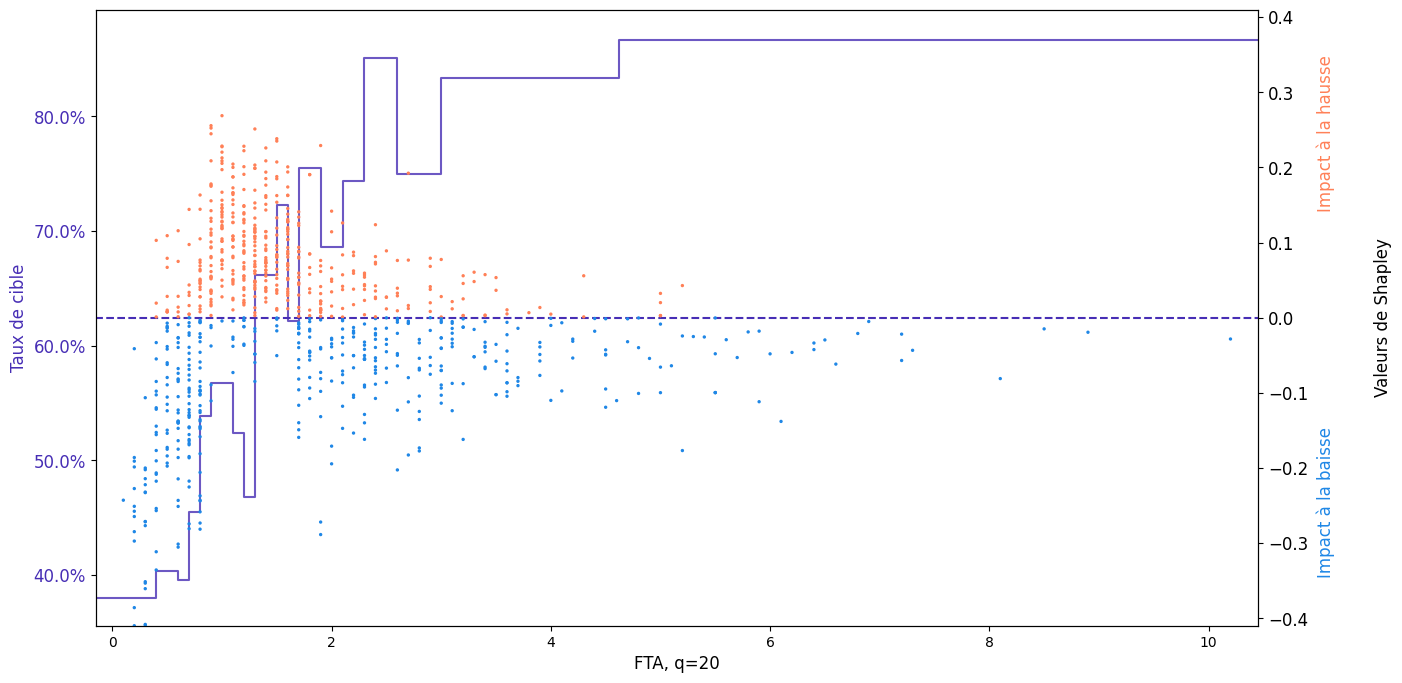

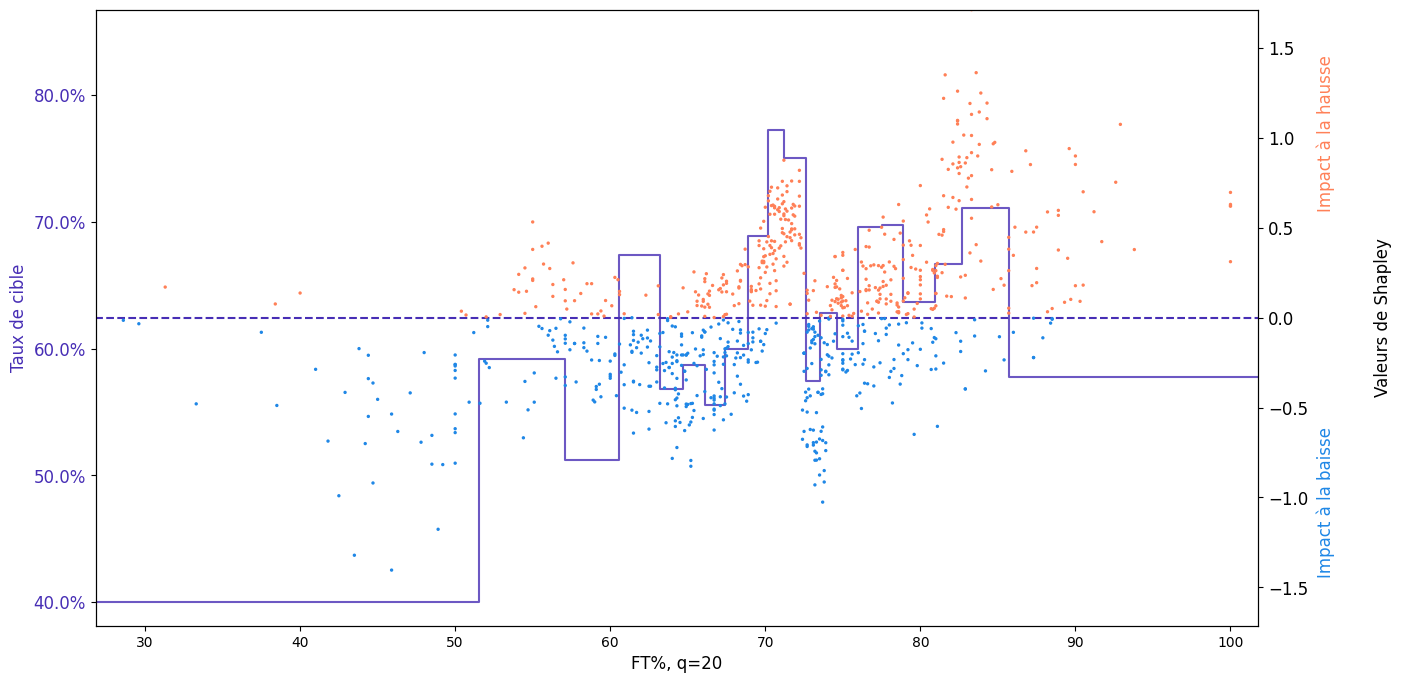

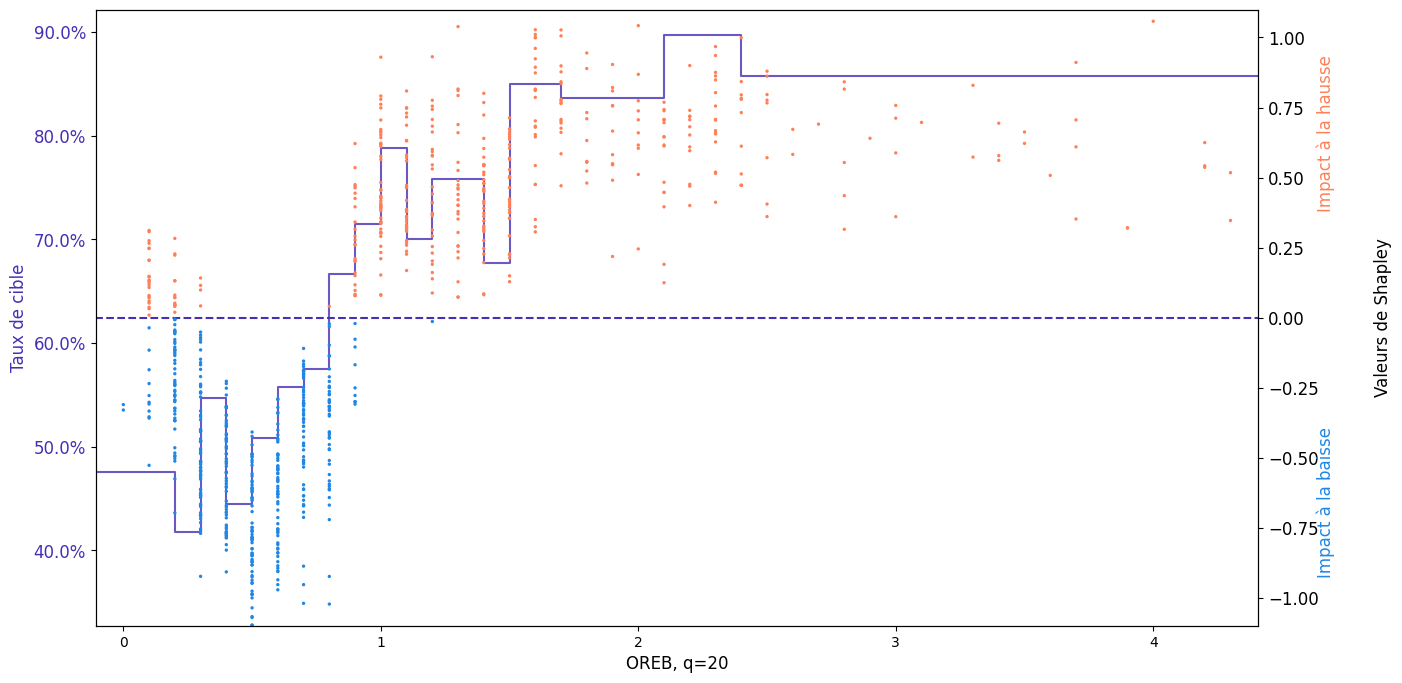

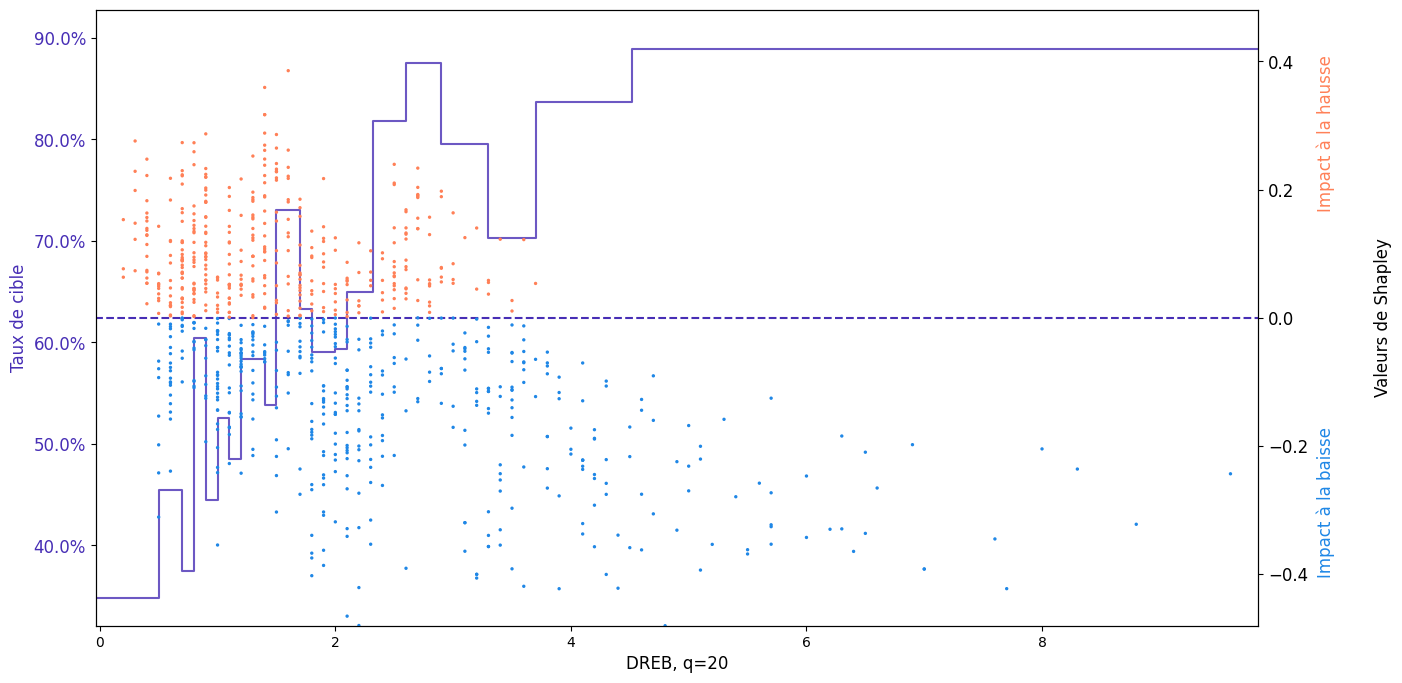

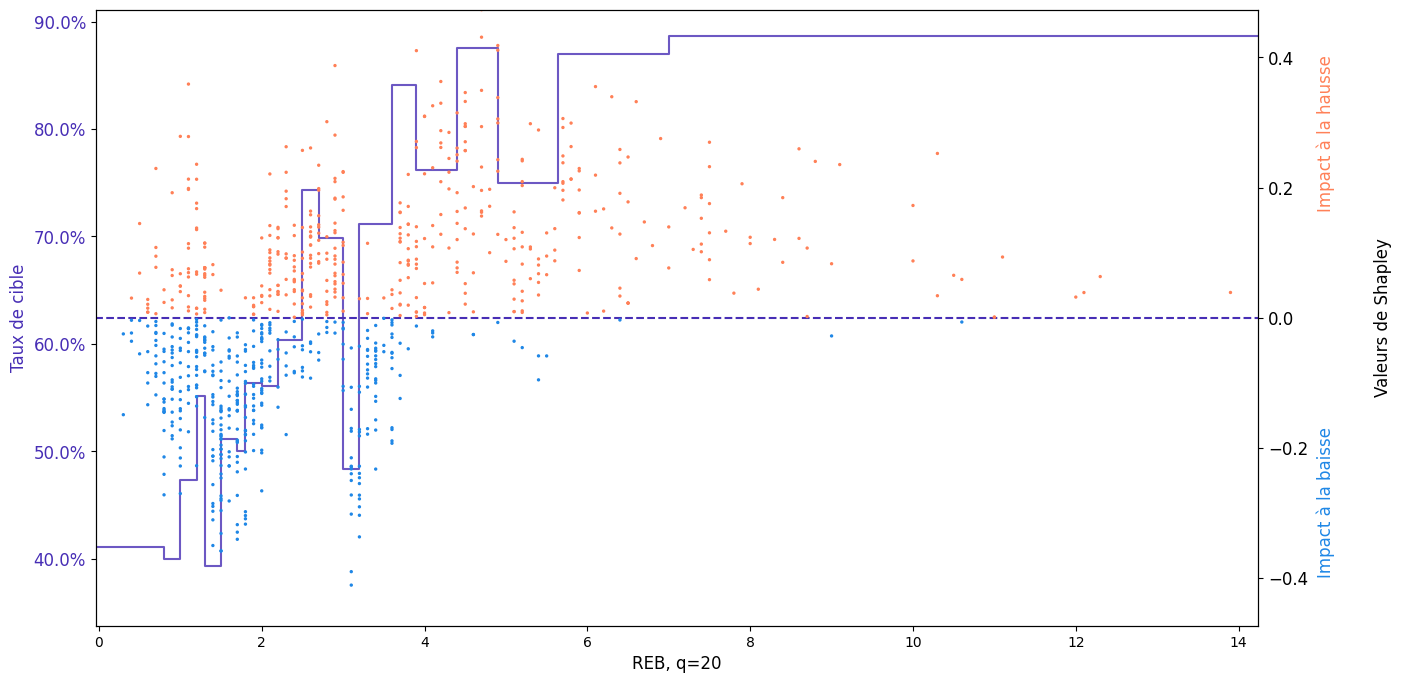

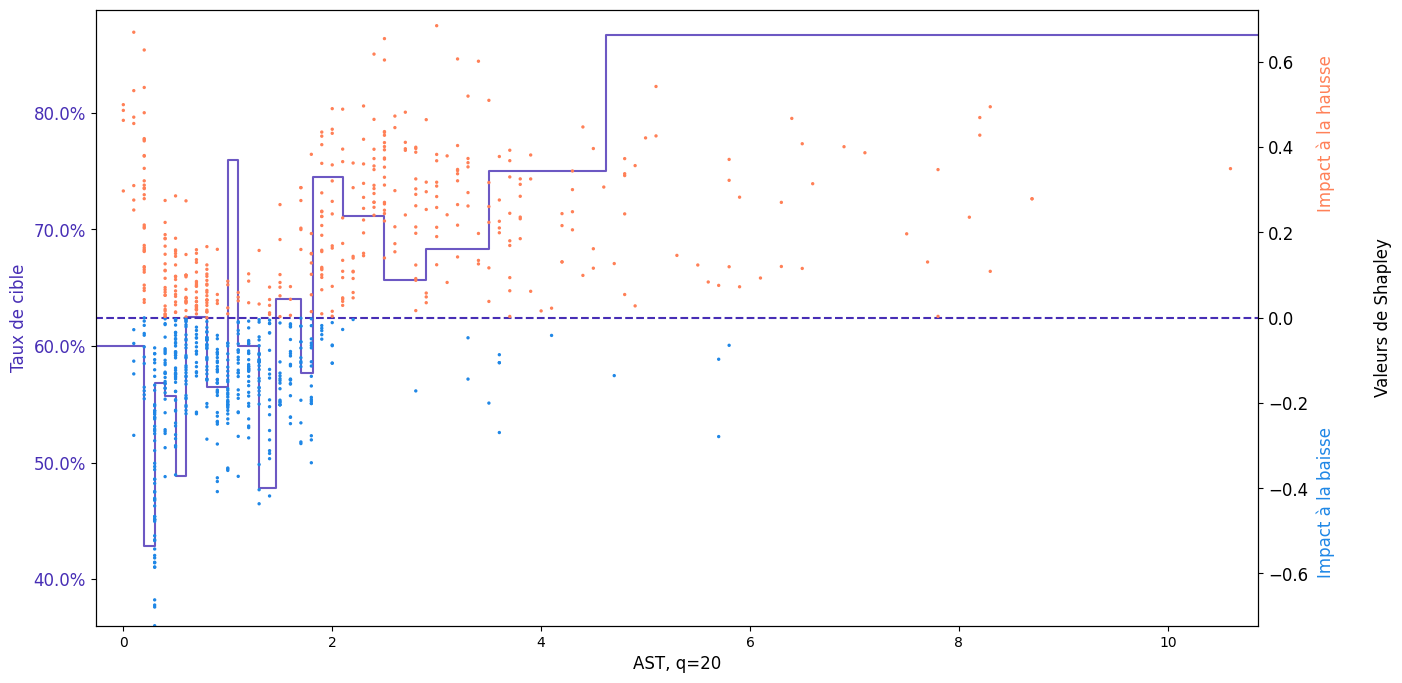

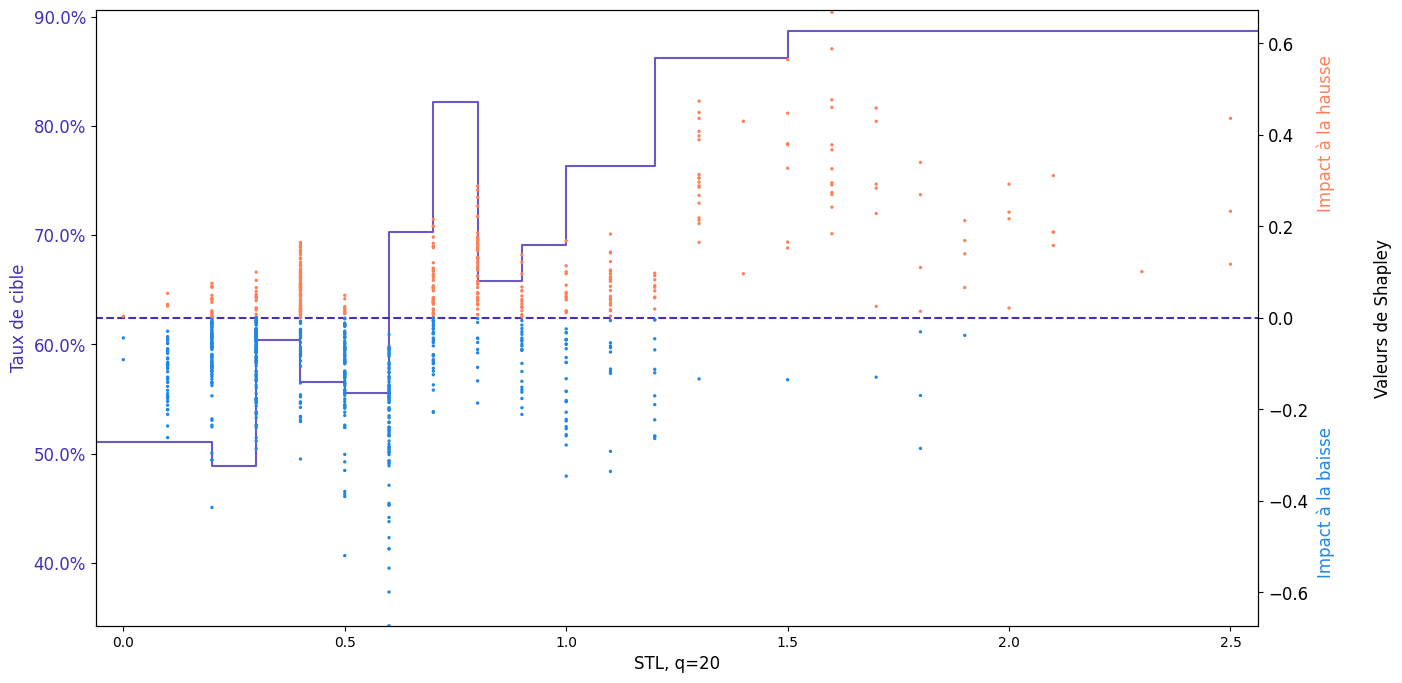

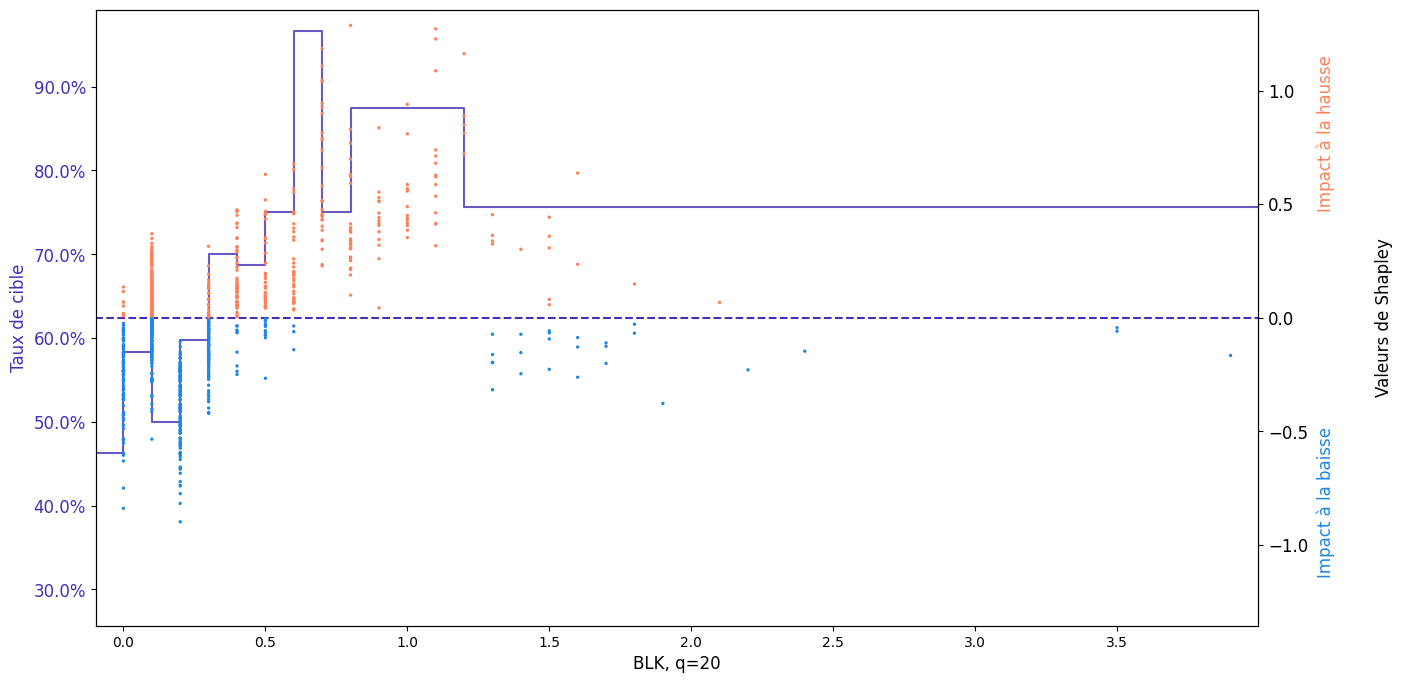

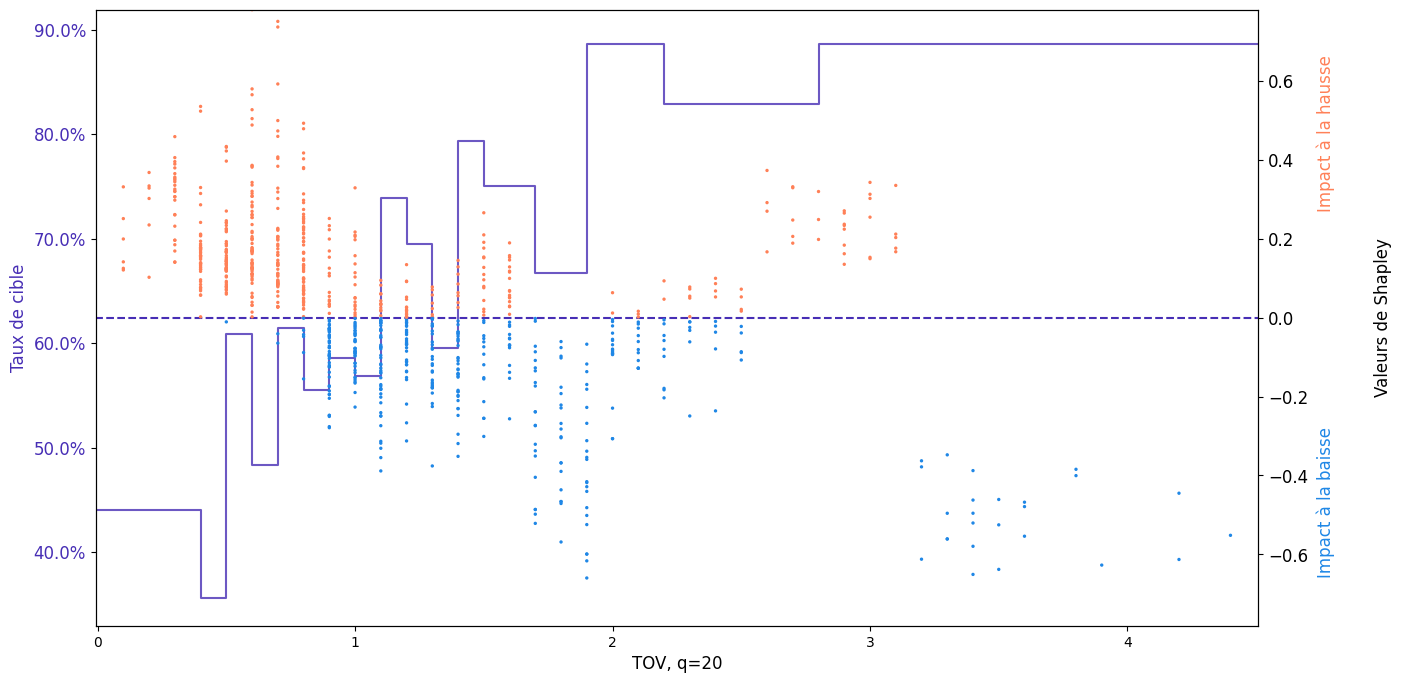

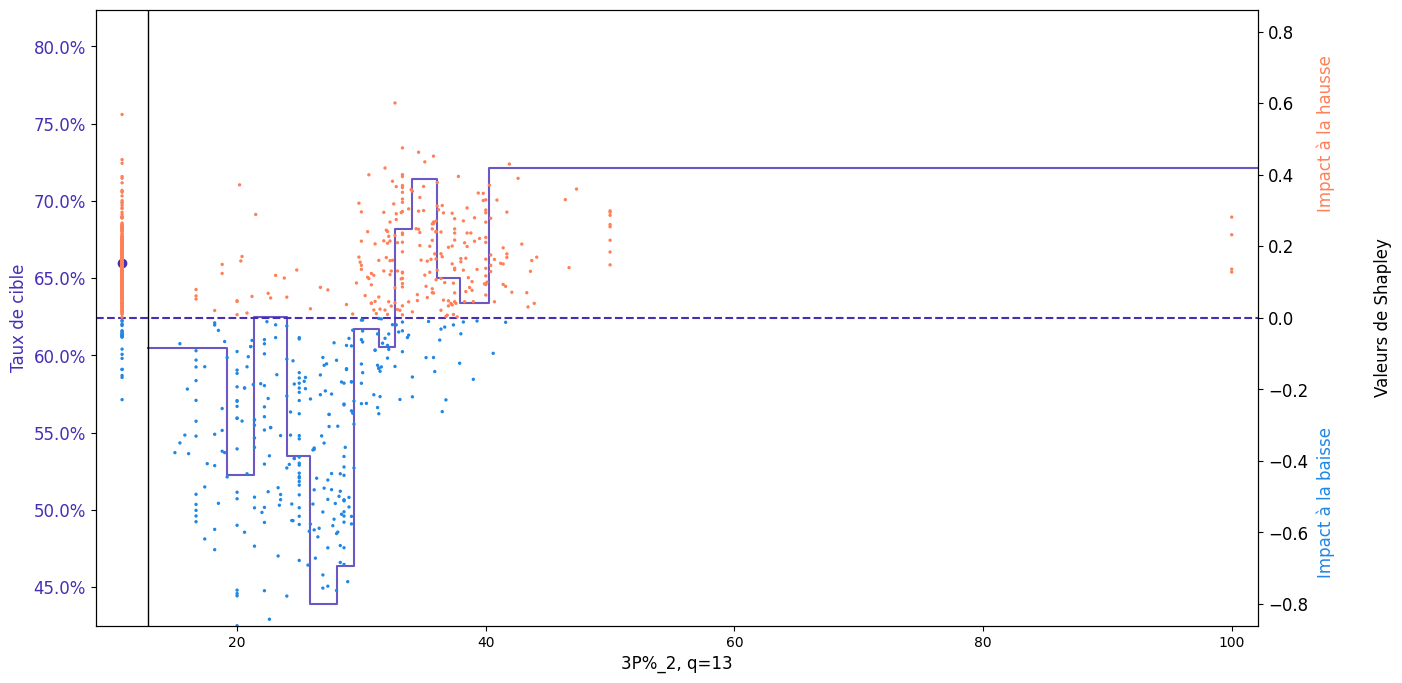

In [12]:
binary_explainer._explain_numerical()

### Interprétabilité de base avec Shap

In [11]:
shap_margin_explainer = shap.TreeExplainer(model=fitted_model, model_output='raw')

shap_values = shap_margin_explainer.shap_values(X_train[selected_features])
# shap_values_test = shap_margin_explainer.shap_values(X_test[selected_features])

# ordered_columns = np.array(selected_features)[np.argsort(np.abs(shap_values).mean(axis=0))]
# ordered_columns

/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


### Shapley values and PDP on categorical features

/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]
/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:177: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]


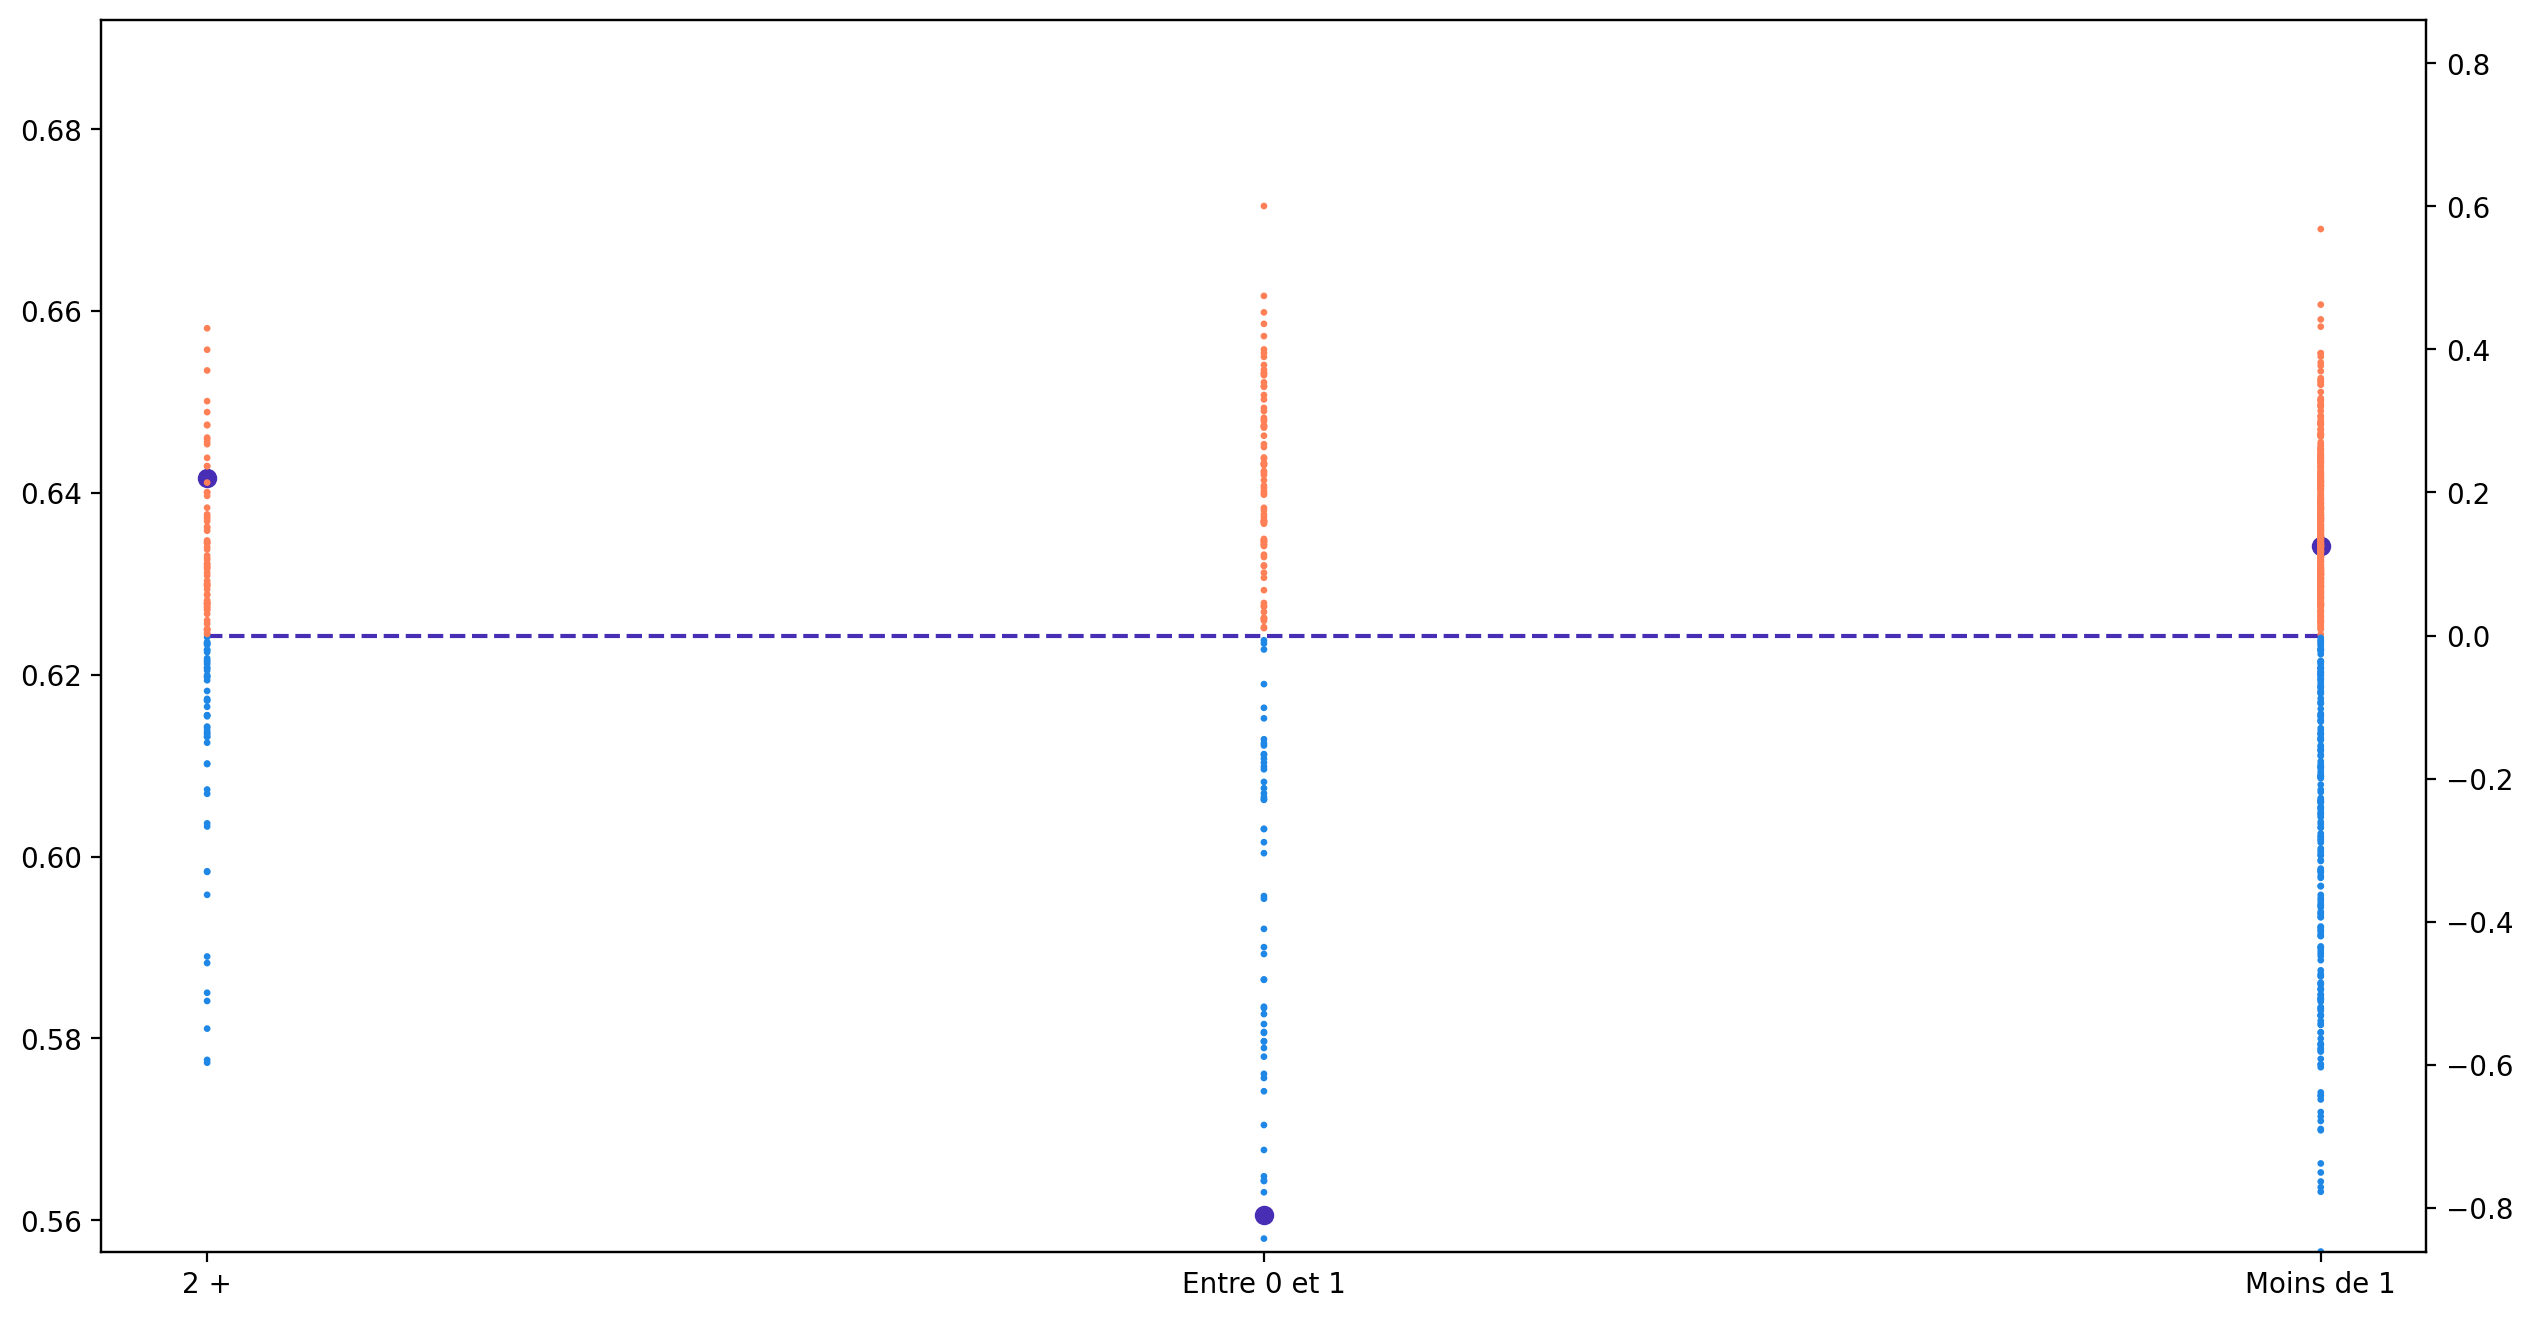

In [10]:
import sys

sys.path.append('../mlexplainer')

from shap_explainer.binary_classification import feature_interpretation, feature_interpretation_category

# Call the function with the correct arguments
feature_interpretation_category("is_ok_3pts", X_train, y_train, target, shap_values)

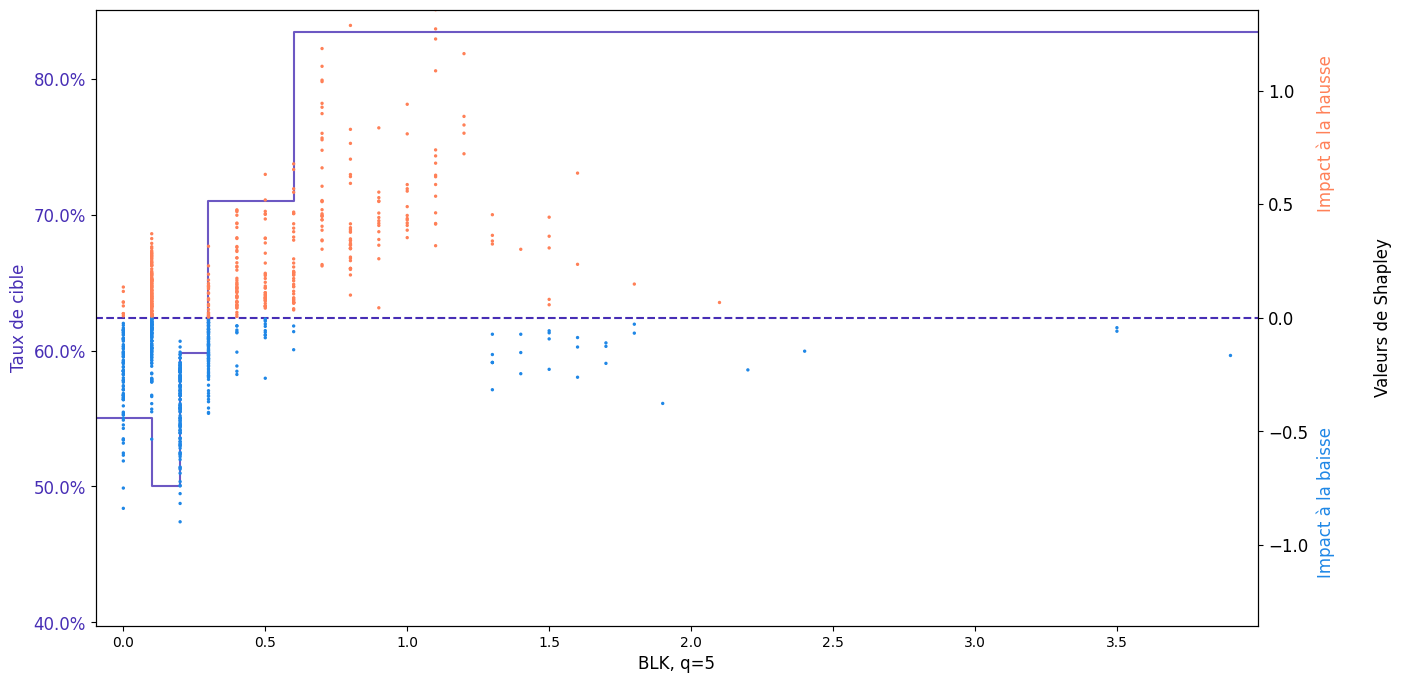

In [11]:
feature_interpretation('BLK', X_train, y_train, shap_values, q=5)

In [12]:
import matplotlib.pyplot as plt

NameError: name 'seaborn' is not defined

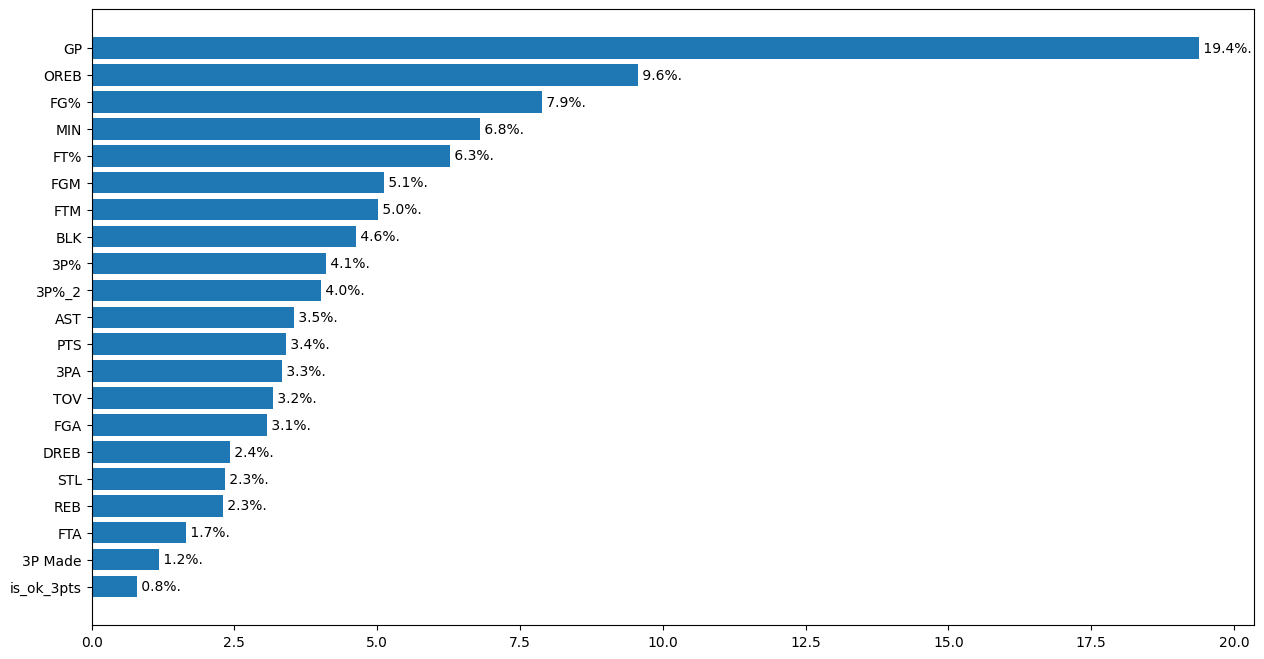

In [13]:
abs_shap = pd.DataFrame(shap_values, columns=selected_features).apply(abs)
total_mean = abs_shap.mean().sum()

relative_importance = (abs_shap.mean().divide(total_mean)*100).reset_index(drop=False).rename(columns={'index':'features', 0:'importances'}).sort_values(by='importances', ascending=True)#.sum()
relative_importance

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.barh(relative_importance['features'], relative_importance['importances'])

for _, row in relative_importance.iterrows():
    ax.text(row.importances, row.features, s=' ' + str(round(row.importances, 1))+'%.', va='center')
    
seaborn.despine(fig)
ax.set_xlabel('Importances')

### Mutli Label Class dependencies

In [14]:
# 
dataframe['random_column'] = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=dataframe.shape[0])
dataframe['random_feature'] = np.random.choice([0, 1, 2, 3, 4], size=dataframe.shape[0])

target = 'random_feature'
selected_features = [c for c in dataframe if (c != target) and c not in ["Name"]]

### Séparation en X et y ###
X, y = dataframe, dataframe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
model = LGBMClassifier()
fitted_model = model.fit(X_train[selected_features], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 23
[LightGBM] [Info] Start training from score -1.611670
[LightGBM] [Info] Start training from score -1.617272
[LightGBM] [Info] Start training from score -1.640001
[LightGBM] [Info] Start training from score -1.562614
[LightGBM] [Info] Start training from score -1.617272


In [16]:
shap_margin_explainer = shap.TreeExplainer(model=fitted_model, model_output='raw')

shap_values = shap_margin_explainer.shap_values(X_train[selected_features])

In [17]:
X_train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,REB,AST,STL,BLK,TOV,TARGET_5Yrs,is_ok_3pts,3P%_2,random_column,random_feature
321,82,23.9,9.4,3.5,7.3,48.1,0.1,0.2,31.3,2.3,...,1.5,4.8,0.8,0.1,1.9,1.0,Moins de 1,31.3,7,3
482,23,8.3,1.3,0.5,1.3,36.7,0.0,0.0,0.0,0.4,...,2.0,0.5,0.1,0.3,0.7,0.0,Moins de 1,NaN,4,2
787,57,19.0,7.6,2.7,6.7,40.1,0.1,0.3,18.8,2.2,...,2.3,2.8,0.9,0.1,1.4,1.0,Moins de 1,18.8,0,0
1053,70,9.2,2.0,0.8,1.6,48.7,0.0,0.0,100.0,0.4,...,2.2,0.3,0.1,0.1,0.4,1.0,Moins de 1,100.0,7,3
1214,44,13.0,6.6,2.5,5.6,45.3,0.4,1.3,32.7,1.1,...,1.4,1.1,0.7,0.2,1.0,0.0,Entre 0 et 1,32.7,1,4


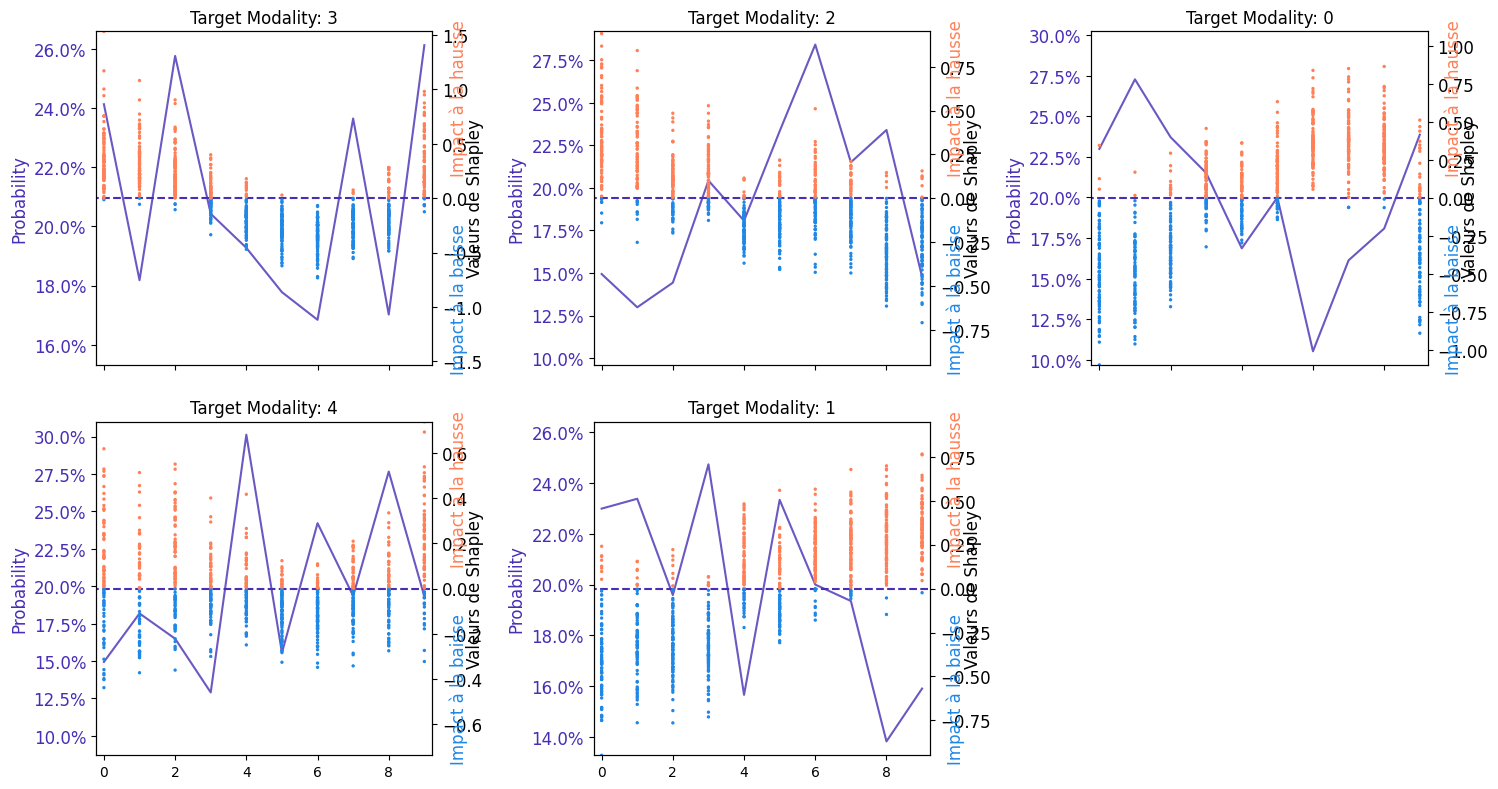

In [19]:
import sys
sys.path.append("../mlexplainer")

from shap_explainer.multilabels_classification import feature_interpretation_multimodal, feature_interpretation_multimodal_category


feature_interpretation_multimodal('random_column', X_train, y_train, shap_values, q=5)

/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]
/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:177: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]
/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:169: FutureWarning: The default of obser

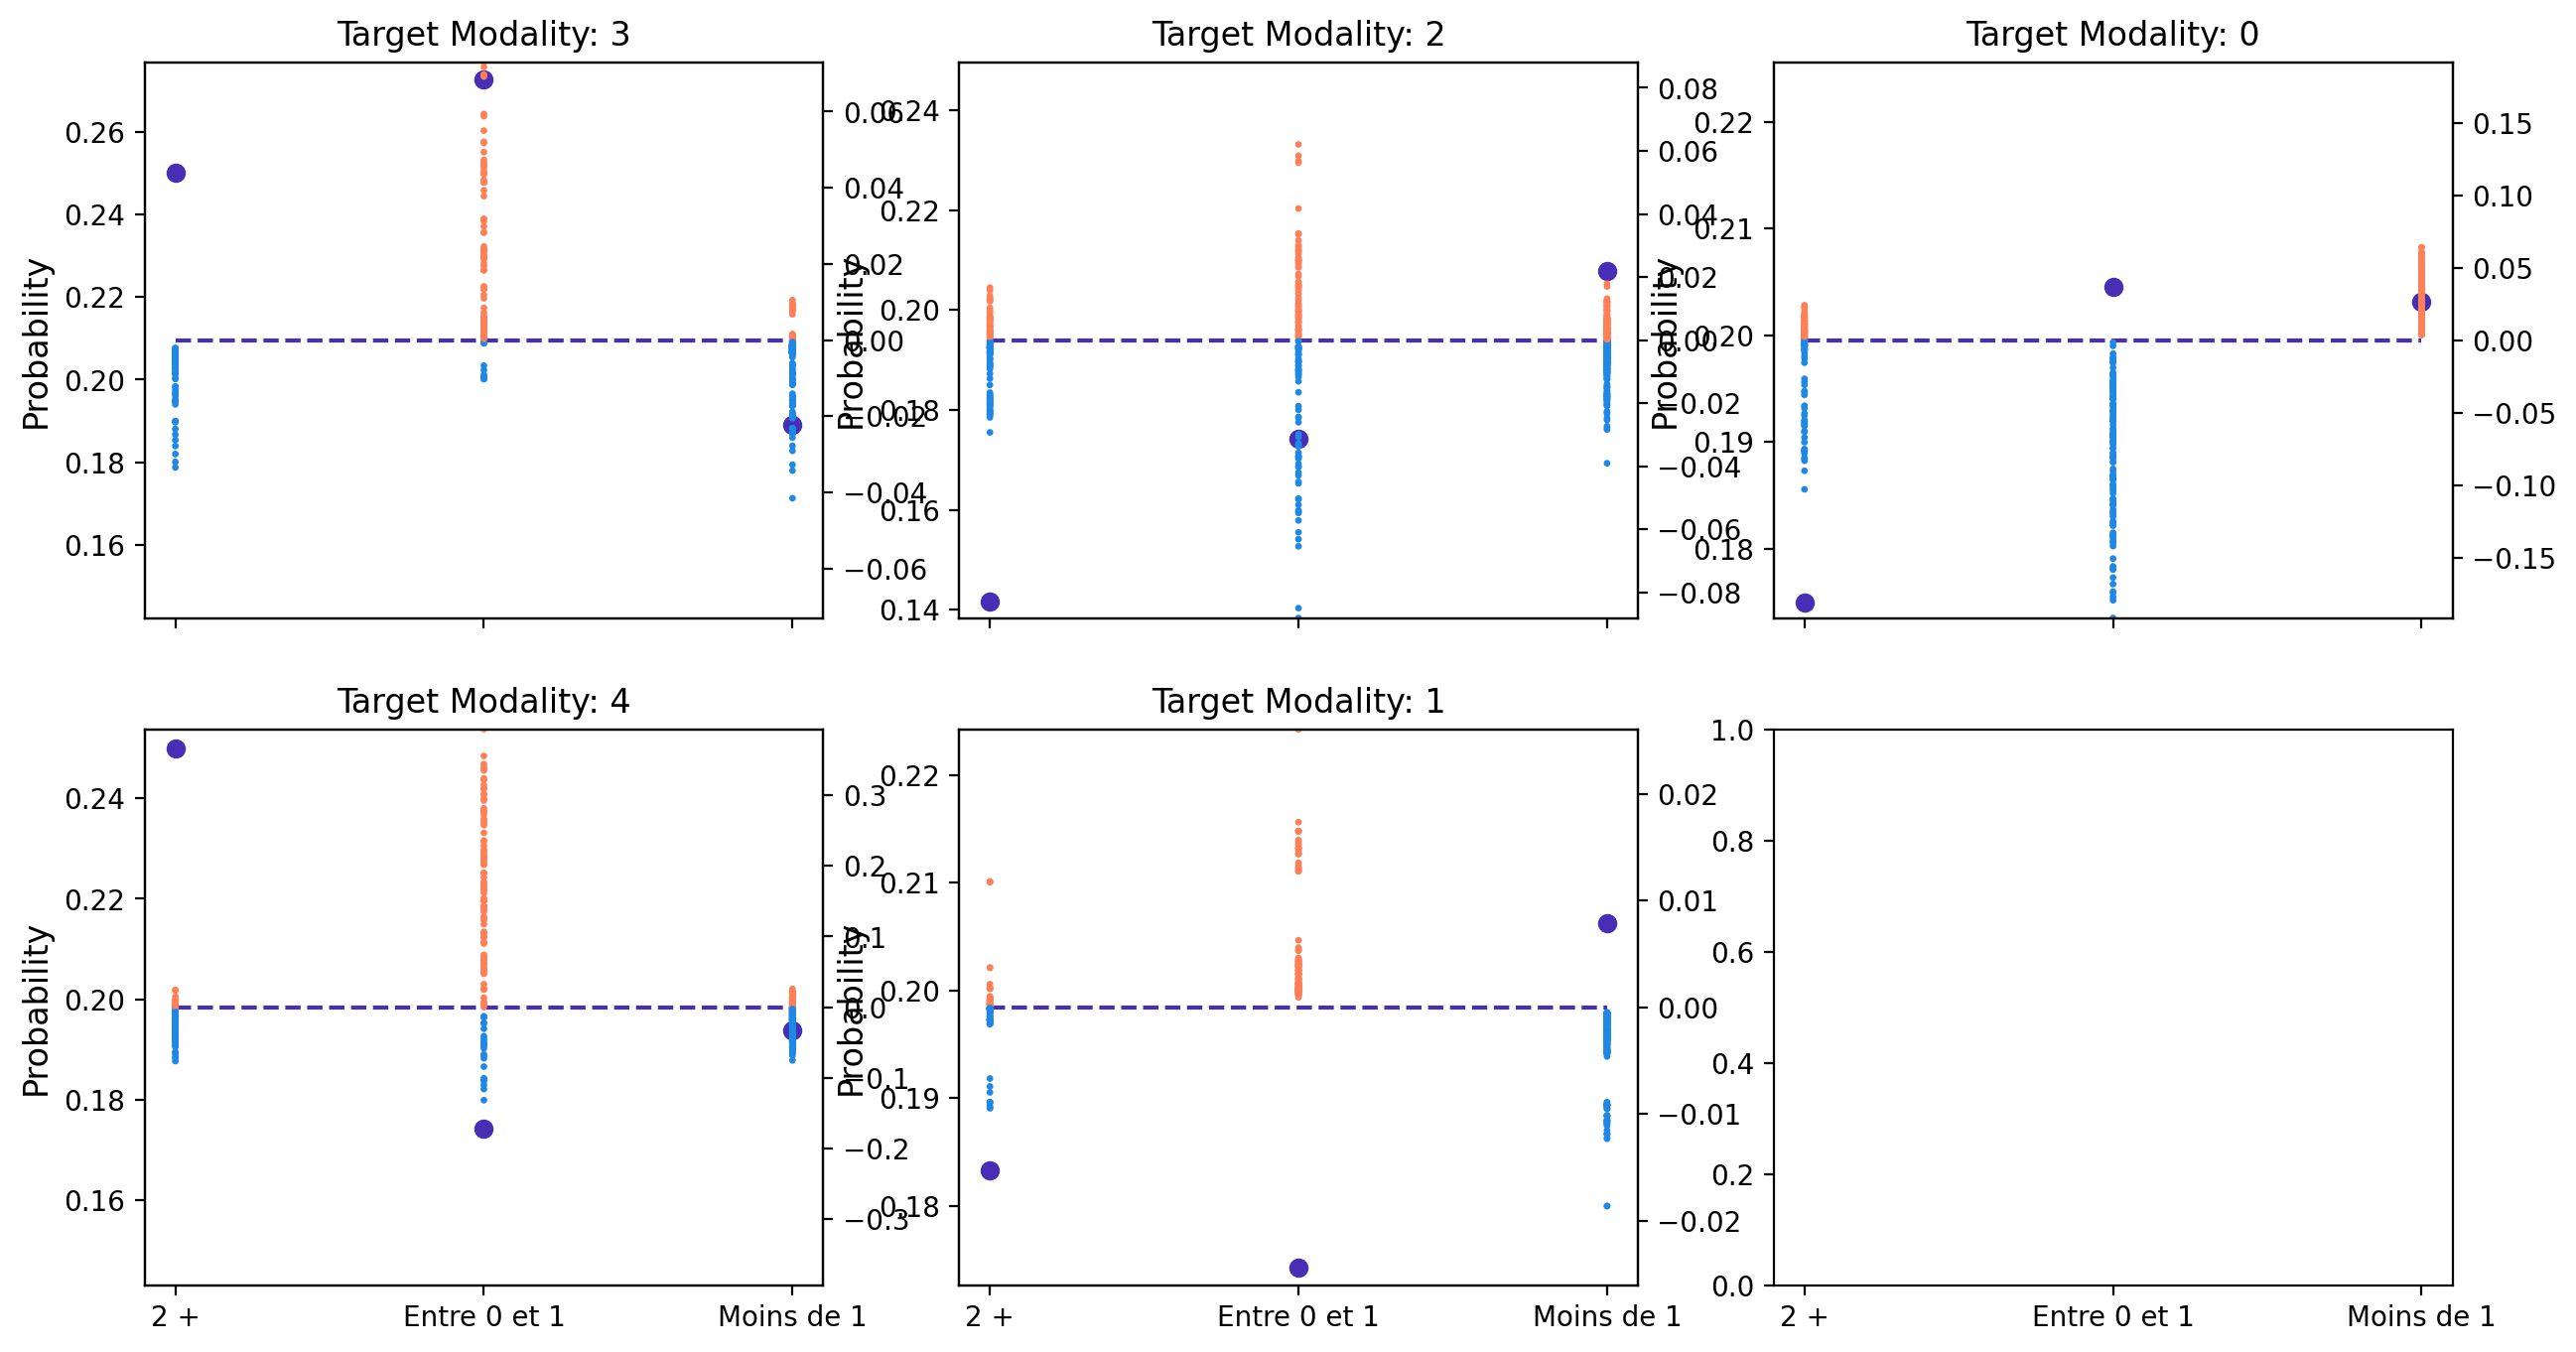

In [20]:
from shap_explainer.multilabels_classification import feature_interpretation_multimodal_category

feature_interpretation_multimodal_category('is_ok_3pts', X_train, y_train, 'random_feature', shap_values)